In [202]:
import numpy as np
from PIL.features import check
from numpy.ma.core import indices
import matplotlib.pyplot as plt
import time

In [208]:
# params --> jakiś specjalny plik json
# od razu funkcja taka, żeby z tym działało,
# ale wczytanie danych do formatu pythona przed
# tą funkcją

# czy my checemy jakąś osobną funkcję do zamiany
# danych na json??? (chyba)

# position weight matrix:
tmp = np.array([[3/8,1/8,2/8,2/8],[1/10,2/10,3/10,4/10],[1/7,2/7,1/7,3/7]])
Theta = tmp.T

# background distribution
ThetaB=np.array([1/4,1/4,1/4,1/4])

params = {
    "w" : 3,
    "alpha" : 0.5,
    "k" : 10,
    "Theta" : Theta.tolist(),
    "ThetaB" : ThetaB.tolist()
    }

# setup to są te słowniki params
def generate_data(setup):
    # wartości, z których chcemy robić ciągi
    values = np.array([1, 2, 3, 4])

    w, alpha, k, Theta, ThetaB = setup.values()
    Theta = np.asarray(Theta)
    ThetaB = np.asarray(ThetaB)

    X = np.empty((k, w))
    mask = np.full((k, w), False)
    # losujemy, z jakiego rozkładu ma pochodzić rząd (próba)
    probs = np.random.rand(k)
    chosen_rows = probs <= alpha
    mask[chosen_rows] = True

    for i in range(w):
        col_mask = mask[:,i]
        m = np.sum(col_mask)
        m_val = np.random.choice(values, m, p = Theta[:,i])

        X[:,i][col_mask] = m_val

    b = np.sum(~mask)
    b_val = np.random.choice(values, b, p = ThetaB)
    X[~mask] = b_val

    return {"alpha": alpha,
            "data": X}


In [212]:
# liczy odległość między rozkładami
# działa dla Theta i ThetaB
# dla alpha liczone osobno
def tv_dist(origin, est):
    return np.sum(np.sum(np.abs(origin - est), axis = 0) / 2)

def initialize_params(X, method = "data"):
    # na wszelki wypadek sobie zmieniamy
    X = np.asarray(X)
    k, w = X.shape

    if method == "data":
        ThetaB = np.empty(4)
        Theta = np.empty([4, w])
        for i in [1, 2, 3, 4]:
            mask = X == i
            row = i - 1
            ThetaB[row] = np.sum(mask) / (k * w)
            Theta[row, :] = np.sum(mask, axis=0) / k
        return Theta, ThetaB

    elif method == "uniform":
        # Jednolity rozkład
        Theta = np.ones([4, w]) / 4
        ThetaB = np.ones(4) / 4
        return Theta, ThetaB

    elif method == "random":
        Theta = np.array([np.random.dirichlet(np.ones(4)) for _ in range(w)]).T  # shape (4, w)
        ThetaB = np.random.dirichlet(np.ones(4))
        return Theta, ThetaB

    else:
        raise ValueError("Invalid argument for function initialize_params")


def EM(data, est_alpha = False, max_iter = 1000, err = 1e-5, init_method = "data"):
    alpha, X = data.values()
    Theta, ThetaB = initialize_params(X, method = init_method)
    k, w = X.shape

    row_indices = np.intp(X - 1)
    col_indices = np.tile(np.arange(w), (k, 1))

    if est_alpha:
        alpha = 0.5 # zapominamy, że znamy alpha i je estymujemy, a tu inicjalizacja

    dist = 1
    iter = 0
    history = []
    
    while dist > err and iter < max_iter:
        iter += 1

        # wartości Theta, dostosowane do obliczeń
        Theta_c = Theta[row_indices, col_indices]
        ThetaB_c = ThetaB[row_indices]

        f = np.prod(Theta_c, axis = 1)
        fB = np.prod(ThetaB_c, axis = 1)

        # te, Z co są równe 1
        latent = f * alpha / ((f * alpha) + (fB * (1 - alpha)))
        # żeby umożliwić działania wektorowe
        latent = latent[:, np.newaxis]
        Theta_lam = np.sum(latent)
        ThetaB_lam = np.sum(1 - latent) * w

        alpha_est = alpha

        if est_alpha:
            alpha_est = np.mean(latent)

        Theta_est = Theta.copy()
        ThetaB_est = ThetaB.copy()

        for i in [1, 2, 3, 4]:
            mask = X == i
            row = i - 1

            ThetaB_est[row] = np.sum(mask * (1 -  latent)) / ThetaB_lam
            Theta_est[row, :] = np.sum(mask * latent, axis=0) / Theta_lam

        if est_alpha:
            dist = (tv_dist(Theta, Theta_est) + tv_dist(ThetaB, ThetaB_est) + np.abs(alpha - alpha_est) / 2) / (w + 2)
            alpha = alpha_est
        else:
            dist = (tv_dist(Theta, Theta_est) + tv_dist(ThetaB, ThetaB_est)) / (w + 1)

        history.append(dist)
        Theta = Theta_est
        ThetaB = ThetaB_est

    return {"alpha": alpha,
            "Theta": Theta,
            "ThetaB": ThetaB,
           "history":history}

some notes:
- different initialization methods (random, uniform, the natural initialization is the one oktawia already implemented i think)
- EM convergency
- d_{tv} depending on starting \alpha
- does knowing the alpha improve d_{tv}?
- 
- 

Jagiela:
- pole do manewru: warunek stopu
- poczatkowa wartosc od ktorej zaczynamy algorytm (naturalny, sensowny prior/random)
- jak zyskuje/traci gdy zmieniaja sie rozmiar danych (k) i dlugosc ciagow tych danych (w) - jakas asymptotyka?
- dobra implementacja == dobre $d_{tv}$


$\textbf{all results are very unstable - average under diffferent seeds}$

In [214]:
#dane wejściowe
tmp = np.array([[3/8,1/8,2/8,2/8],[1/10,2/10,3/10,4/10],[1/7,2/7,1/7,3/7]])
Theta = tmp.T
ThetaB=np.array([1/4,1/4,1/4,1/4])

params = {
    "w" : 3,
    "alpha" : 0.1,
    "k" : 200,
    "Theta" : Theta.tolist(),
    "ThetaB" : ThetaB.tolist()
    }


convergency of EM vs different initialization methods (alpha known and estimated)

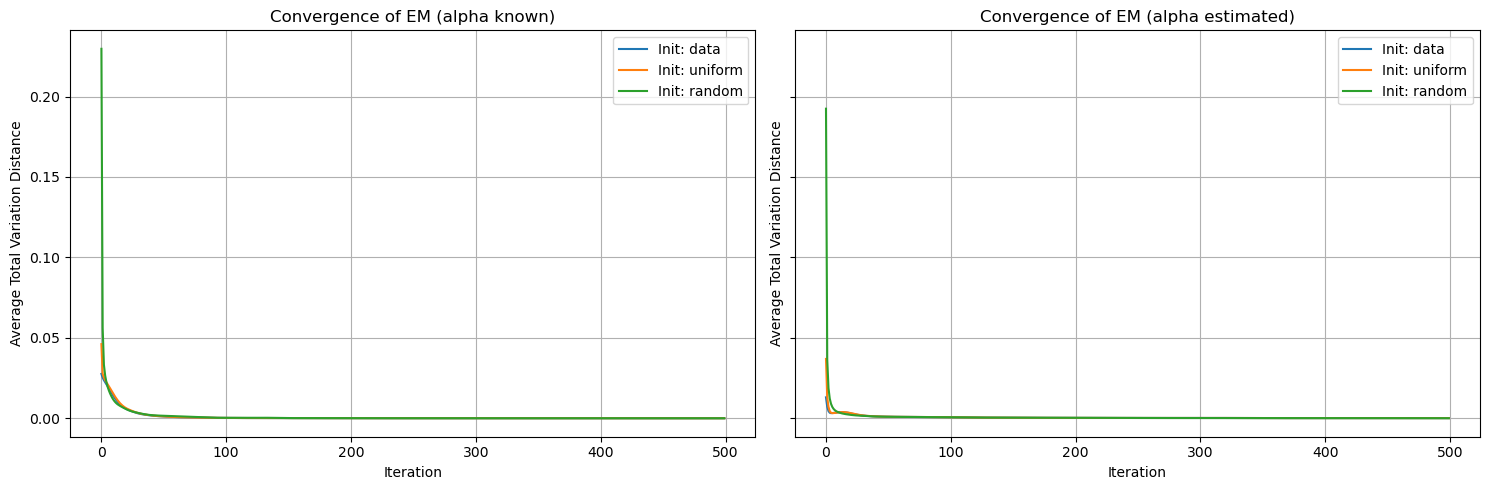

		 took 13.74936 seconds 


In [216]:
init_methods = ["data", "uniform", "random"]
n_runs = 100  # liczba powtórzeń
max_iters = 500  # maksymalna długość historii do uśrednienia

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
start_time = time.time()
convergence_iters = {} # zliczam ilosc iteracji do zbiegu
for ax, est_alpha in zip(axes, [False, True]):
    for method in init_methods:
        histories = []

        for seed in range(n_runs):
            np.random.seed(seed)
            data = generate_data(params)
            res = EM(data, init_method=method, est_alpha=est_alpha)
    
            h = np.array(res["history"])

            key = (est_alpha, method)
            if key not in convergence_iters:
                convergence_iters[key] = []
            convergence_iters[key].append(len(h))

            if len(h) < max_iters:
                h = np.pad(h, (0, max_iters - len(h)), constant_values=h[-1])
            else:
                h = h[:max_iters]

            histories.append(h)
            

        avg_history = np.mean(histories, axis=0)
        ax.plot(avg_history, label=f"Init: {method}")

    ax.set_title(f"Convergence of EM (alpha {'estimated' if est_alpha else 'known'})")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Average Total Variation Distance")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()
print("\t\t took %s seconds " % round((time.time() - start_time),5))


In [217]:
means = []
stds = []
labels = []
for (est_alpha, method), values in convergence_iters.items():
    m = np.mean(values)
    s = np.std(values)
    label = f"{method} | alpha {'est' if est_alpha else 'known'}"
    print(f"{label}: mean={m:.2f}, std={s:.2f}")
    means.append(m)
    stds.append(s)
    labels.append(label)


data | alpha known: mean=176.19, std=79.57
uniform | alpha known: mean=177.19, std=79.57
random | alpha known: mean=185.57, std=90.25
data | alpha est: mean=495.28, std=274.83
uniform | alpha est: mean=496.17, std=274.63
random | alpha est: mean=437.89, std=276.03


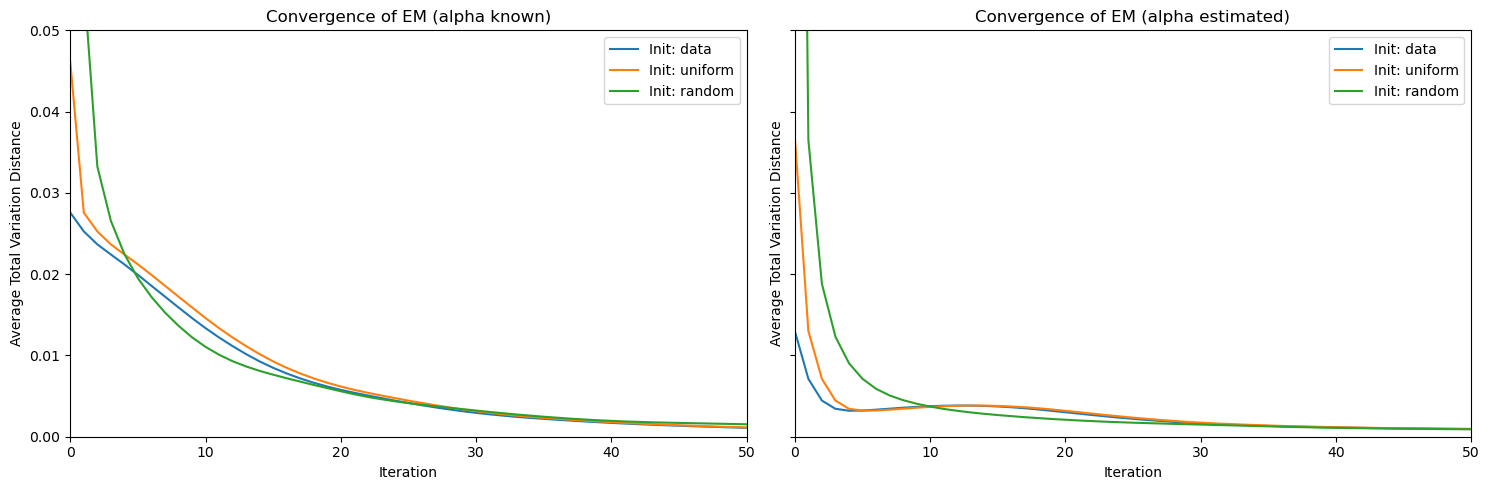

		 took 13.53664 seconds 


In [218]:
init_methods = ["data", "uniform", "random"]
n_runs = 100  # liczba powtórzeń
max_iters = 500  # maksymalna długość historii do uśrednienia

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
start_time = time.time()
for ax, est_alpha in zip(axes, [False, True]):
    for method in init_methods:
        histories = []

        for seed in range(n_runs):
            np.random.seed(seed)
            data = generate_data(params)
            res = EM(data, init_method=method, est_alpha=est_alpha)

            h = np.array(res["history"])
            if len(h) < max_iters:
                h = np.pad(h, (0, max_iters - len(h)), constant_values=h[-1])
            else:
                h = h[:max_iters]

            histories.append(h)

        avg_history = np.mean(histories, axis=0)
        ax.plot(avg_history, label=f"Init: {method}")

    ax.set_title(f"Convergence of EM (alpha {'estimated' if est_alpha else 'known'})")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Average Total Variation Distance")
    ax.legend()
    ax.grid
    ax.set_xlim(0, 50) # zblizenie na roznice
    ax.set_ylim(0, 0.05)

plt.tight_layout()
plt.show()
plt.show()
print("\t\t took %s seconds " % round((time.time() - start_time),5))

EM convergence vs number of observations

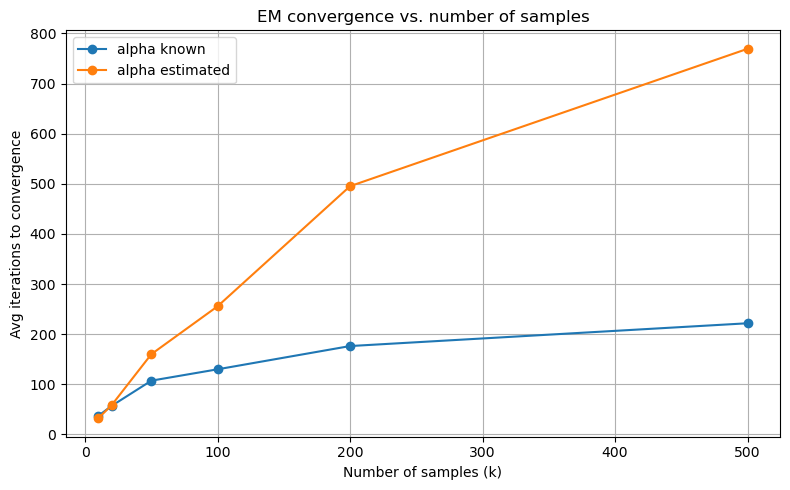

		 took 19.27974 seconds 


In [219]:
ks = [10, 20, 50, 100, 200, 500]
init_method = "data" # for all menthods these plots look pretty much the same
n_runs = 100

iterations_known = []
iterations_estimated = []
start_time = time.time()
for k in ks:
    iters_k = []
    iters_est = []
    params["k"] = k

    for seed in range(n_runs):
        np.random.seed(seed)
        data = generate_data(params)

        res_known = EM(data, init_method=init_method, est_alpha=False)
        res_est = EM(data, init_method=init_method, est_alpha=True)

        iters_k.append(len(res_known["history"]))
        iters_est.append(len(res_est["history"]))

    iterations_known.append(np.mean(iters_k))
    iterations_estimated.append(np.mean(iters_est))

plt.figure(figsize=(8, 5))
plt.plot(ks, iterations_known, marker='o', label='alpha known')
plt.plot(ks, iterations_estimated, marker='o', label='alpha estimated')
plt.xlabel("Number of samples (k)")
plt.ylabel("Avg iterations to convergence")
plt.title("EM convergence vs. number of samples")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
print("\t\t took %s seconds " % round((time.time() - start_time),5))

In [181]:
def make_theta(w): #i couldnt use params Theta for other values of w  
    Theta = np.array([np.random.dirichlet(np.ones(4)) for _ in range(w)]).T  # shape (4, w)
    ThetaB = np.random.dirichlet(np.ones(4))
    return Theta.tolist(), ThetaB.tolist()

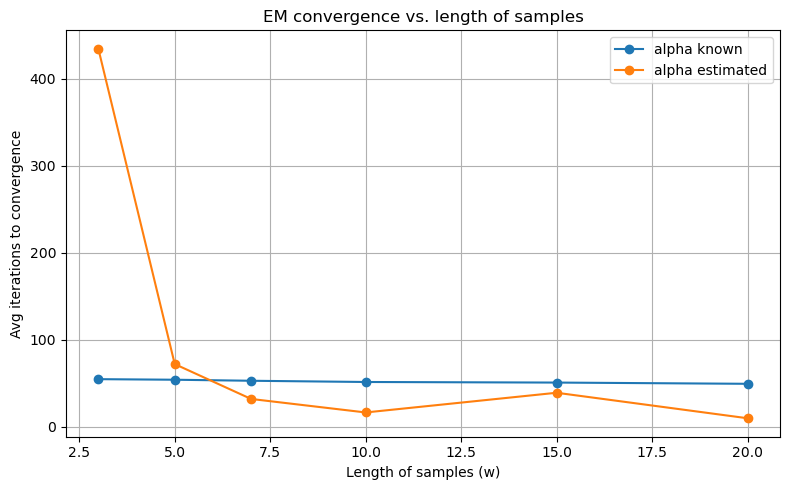

		 took 9.56675 seconds 


In [232]:
ws = [3, 5, 7, 10, 15, 20]
init_method = "data" 
n_runs = 100

iterations_known = []
iterations_estimated = []
start_time = time.time()
for w in ws:
    iters_w = []
    iters_est = []
    Theta, ThetaB = make_theta(w)
    
    params["w"] = w
    params["Theta"] = Theta
    params["ThetaB"] = ThetaB

    for seed in range(n_runs):
        np.random.seed(seed+5)
        data = generate_data(params)
        res_known = EM(data, init_method=init_method, est_alpha=False)
        res_est = EM(data, init_method=init_method, est_alpha=True)

        iters_k.append(len(res_known["history"]))
        iters_est.append(len(res_est["history"]))

    iterations_known.append(np.mean(iters_k))
    iterations_estimated.append(np.mean(iters_est))

plt.figure(figsize=(8, 5))
plt.plot(ws, iterations_known, marker='o', label='alpha known')
plt.plot(ws, iterations_estimated, marker='o', label='alpha estimated')
plt.xlabel("Length of samples (w)")
plt.ylabel("Avg iterations to convergence")
plt.title("EM convergence vs. length of samples")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
print("\t\t took %s seconds " % round((time.time() - start_time),5))

In [318]:
#w = 7
#Theta = np.array([np.random.dirichlet(np.ones(4)) for _ in range(w)]).T
#print(Theta)
#print(np.sum(Theta, axis=0))
#print(np.random.dirichlet(np.ones(4)))

[0.04316047 0.53833837 0.34822033 0.07028083]


More important -- testing the quality of convergency under different scenarious, $d_{tv}$ 
degrees of freedom :
- number of observations $k$,
- length of each observation $w$,
- initialization parameters $\Theta$,
- starting alpha (probability of choosing distributions)

In [254]:
# needed functions:

def make_params(k, w, alpha=0.5): # we need it for diffent ws
    Theta = np.array([np.random.dirichlet(np.ones(4)) for _ in range(w)]).T
    ThetaB = np.random.dirichlet(np.ones(4))
    return {
        "w": w,
        "alpha": alpha,
        "k": k,
        "Theta": Theta.tolist(),
        "ThetaB": ThetaB.tolist()
    }, Theta, ThetaB

def avg_dtv(Theta1, Theta2): # d_tv comparing real_theta and estimated_theta
    return np.mean([
        0.5 * np.sum(np.abs(np.array(c1) - np.array(c2)))
        for c1, c2 in zip(np.array(Theta1).T, np.array(Theta2).T)
    ])

def dtv_total(Theta_est, Theta_true, ThetaB_est, ThetaB_true):
    d1 = avg_dtv(Theta_est, Theta_true)
    d2 = 0.5 * np.sum(np.abs(np.array(ThetaB_est) - np.array(ThetaB_true)))
    return (d1 * w + d2) / (w + 1)

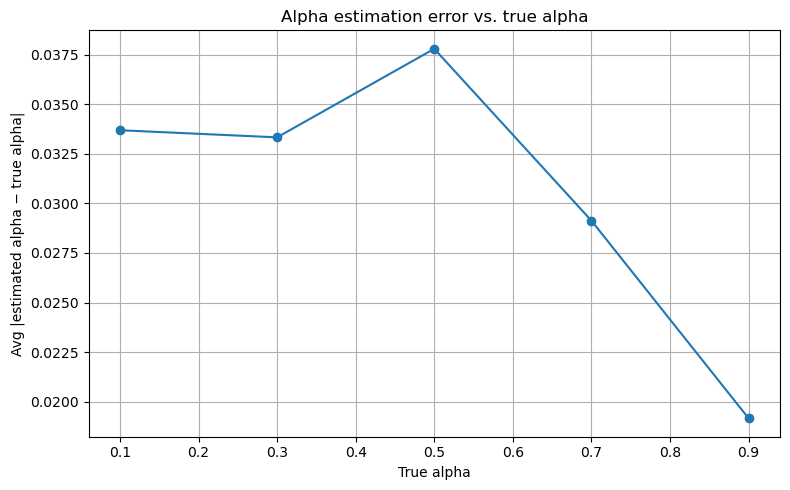

		 took 1.56779 seconds 


In [346]:
# how good the estimation of alpha is depending on true value
# the results are VERY unstable, have to repeat it 100times and take the average
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
n_runs = 100
alpha_errors = []
start_time = time.time()
for alpha in alphas:
    errors = []

    for seed in range(n_runs):
        np.random.seed(seed)
        
        params["alpha"] = alpha
        data = generate_data(params)
        res = EM(data, init_method="data", est_alpha=True)

        alpha_est = res["alpha"]
        errors.append(abs(alpha_est - alpha))

    alpha_errors.append(np.mean(errors))

# Rysowanie wykresu
plt.figure(figsize=(8, 5))
plt.plot(alphas, alpha_errors, marker='o')
plt.xlabel("True alpha")
plt.ylabel("Avg |estimated alpha − true alpha|")
plt.title("Alpha estimation error vs. true alpha")
plt.grid()
plt.tight_layout()
plt.show()
print("\t\t took %s seconds " % round((time.time() - start_time),5))

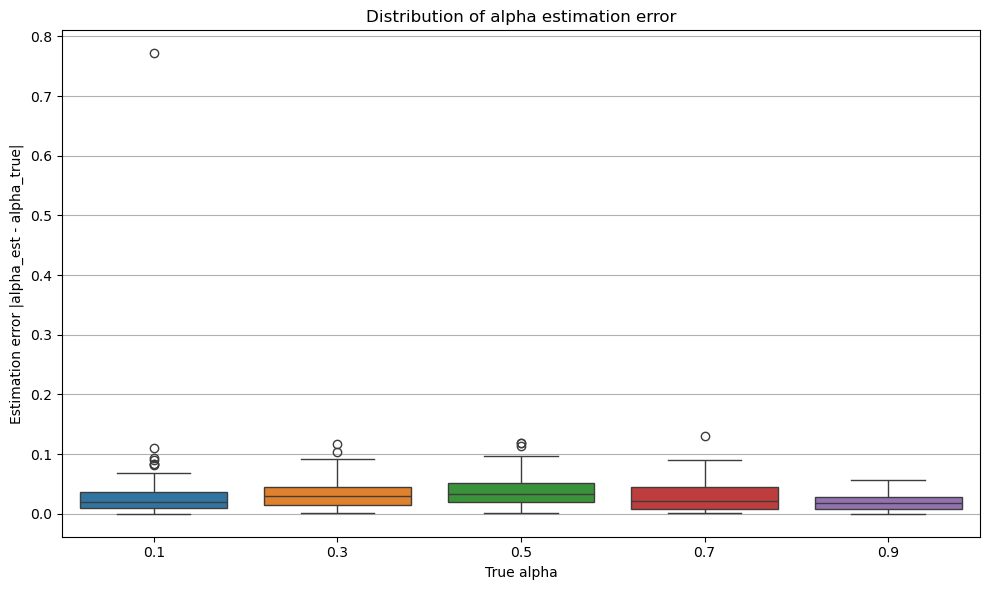

		 took 1.60497 seconds 


In [334]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
n_runs = 100
alpha_errors_all = []
start_time = time.time()
for alpha in alphas:
    errors = []

    for seed in range(n_runs):
        np.random.seed(seed)

        params["alpha"] = alpha

        data = generate_data(params)
        res = EM(data, init_method="data", est_alpha=True)

        error = abs(res["alpha"] - alpha)
        errors.append(error)

    alpha_errors_all.append(errors)

# Rysowanie boxplotów
plt.figure(figsize=(10, 6))
sns.boxplot(data=alpha_errors_all)
plt.xticks(ticks=range(len(alphas)), labels=alphas)
plt.xlabel("True alpha")
plt.ylabel("Estimation error |alpha_est - alpha_true|")
plt.title("Distribution of alpha estimation error")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
print("\t\t took %s seconds " % round((time.time() - start_time),5))

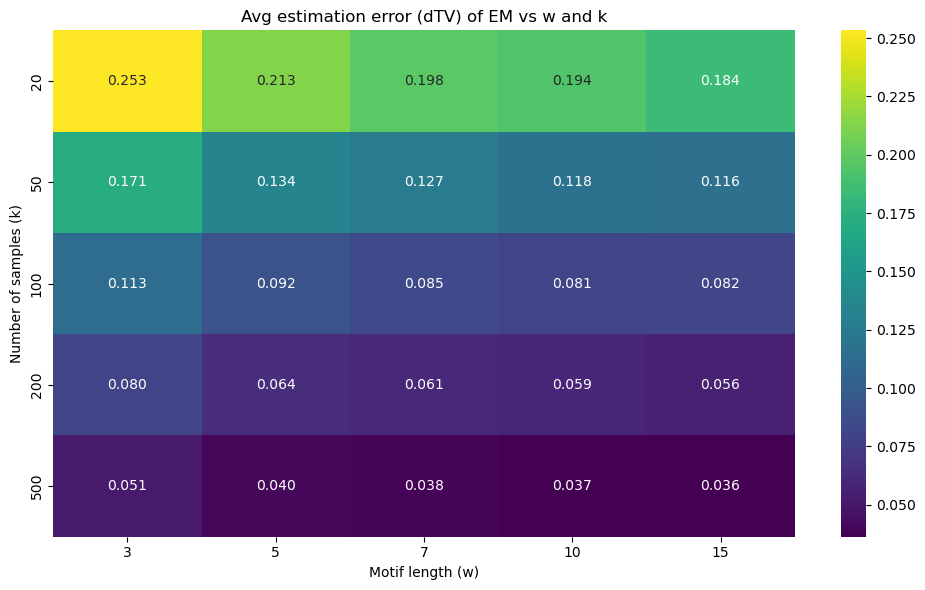

		 took 8.03415 seconds 


In [262]:
w_vals = [3, 5, 7, 10, 15]
k_vals = [20, 50, 100, 200, 500]
n_runs = 100

heat = np.zeros((len(k_vals), len(w_vals)))
start_time = time.time()
for i, k in enumerate(k_vals):
    for j, w in enumerate(w_vals):
        dtvs = []
        for seed in range(n_runs):
            np.random.seed(seed)
            params, Theta_true, ThetaB_true = make_params(k, w)
            data = generate_data(params)

            res = EM(data, init_method="data", est_alpha=True)  # lub False

            d = dtv_total(
                res["Theta"], Theta_true,
                res["ThetaB"], ThetaB_true
            )
            dtvs.append(d)

        heat[i, j] = np.mean(dtvs)

# Rysowanie heatmapy
plt.figure(figsize=(10, 6))
sns.heatmap(heat, annot=True, fmt=".3f", xticklabels=w_vals, yticklabels=k_vals, cmap="viridis")
plt.xlabel("Motif length (w)")
plt.ylabel("Number of samples (k)")
plt.title("Avg estimation error (dTV) of EM vs w and k")
plt.tight_layout()
plt.show()
print("\t\t took %s seconds " % round((time.time() - start_time),5))